# Initialization

In [1]:
import tensorflow as tf
import numpy as np
import cv2
import glob
import pandas as pd
import matplotlib.pyplot as plt


2024-07-08 17:01:53.061354: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
import configs

# Data Loader

In [ ]:
class MyDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, data_dir, batch_size=32, shuffle=True):
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.filenames = glob.glob(data_dir + '/*/*.jpg')
        self.filenames.sort()
        print(len(self.filenames), 'found')
        self.classnames = ['/akiec/', '/bcc/', '/bkl/',
                           '/df/', '/mel/', '/nv/', '/vasc/']
        self.indices = None
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.filenames) / self.batch_size))

    def __getitem__(self, index):
        indices = self.indices[index*self.batch_size:(index+1)*self.batch_size]
        filenames = [self.filenames[k] for k in indices]
        X, Y = self.__data_generation(filenames)
        return X, Y

    def on_epoch_end(self):
        self.indices = np.arange(len(self.filenames))
        if self.shuffle == True:
            np.random.shuffle(self.indices)

    def filename2onehot(self, fn):
        for i in range(configs.NUM_CLASS):
            if self.classnames[i] in fn:
                result = np.zeros(configs.NUM_CLASS, dtype=np.float64)
                result[i] = 1
                return result
        return None

    def __data_generation(self, filenames):
        num = len(filenames)
        X = np.empty([num, *configs.IMAGE_SIZE], dtype=np.float64)
        Y = np.empty([num, configs.NUM_CLASS])
        for i, fn in enumerate(filenames):
            img = cv2.imread(fn)
            delta = (configs.IMAGE_SIZE[1] - configs.IMAGE_SIZE[0]) // 2
            img = img[:, delta:configs.IMAGE_SIZE[1]-delta-1]
            img = cv2.resize(img, (224, 224))
            X[i] = np.array(img, dtype=np.float64) / 255.
            Y[i] = self.filename2onehot(fn)

        return X, Y

In [ ]:
train_datagen = MyDataGenerator(configs.DATA_DIR+'/train')
val_datagen = MyDataGenerator(configs.DATA_DIR+'/val')
test_datagen = MyDataGenerator(configs.DATA_DIR+'/test')

5005 found
2000 found
3010 found


(32, 224, 224, 3) (32, 7)


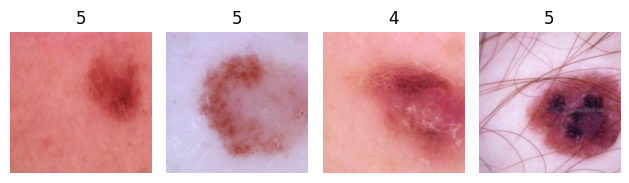

In [ ]:
X, Y = train_datagen[0]
print(X.shape, Y.shape)

for i in range(4):
  plt.subplot(1, 4, i+1)
  plt.imshow(cv2.cvtColor((X[i]*255).astype(np.uint8), cv2.COLOR_BGR2RGB))
  plt.axis('off')
  plt.title(Y[i].argmax())
plt.tight_layout()
plt.show()

# Classifer 224 x 224

In [ ]:
model = tf.keras.models.Sequential(name='classifier224')
model.add(tf.keras.applications.resnet50.ResNet50(
            include_top=False,
            weights='imagenet',
            input_shape=configs.IMAGE_SIZE)
)
model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(tf.keras.layers.Dense(configs.NUM_CLASS, activation='sigmoid'))
model.add(tf.keras.layers.Softmax())
model.summary()

94765736/94765736 [==============================] - 5s 0us/step
Model: "classifier224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 7)                 14343     
                                                                 
 softmax (Softmax)           (None, 7)                 0         
                                                                 
Total params: 23602055 (90.03 MB)
Trainable params: 23548935 (89.83 MB)
Non-trainable params: 53120 (207.50 KB)
_________________________________________________________________


In [ ]:
model.compile(optimizer=tf.optimizers.Adam(learning_rate=1e-4),
              loss=tf.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

# Training

In [ ]:
cb_early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=1e-4,
    patience=8,
    verbose=1,
    mode='auto'
)
cb_model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    configs.CHECKPOINT_DIR + '/' + model.name,
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='auto'
)
cb_reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=5,
    verbose=1,
    mode='auto',
    min_delta=1e-4,
    min_lr=0
)
callbacks = [cb_model_checkpoint,
             cb_reduce_lr,
             cb_early_stop]

In [ ]:
history = model.fit_generator(train_datagen,
                    epochs=2024,
                    verbose=1,
                    callbacks=callbacks,
                    validation_data=val_datagen)

pd.DataFrame.from_dict(history.history) \
           .to_csv(configs.CHECKPOINT_DIR +
                   model.name +
                   '/history_classifer_224x224.csv', index=False)

<ipython-input-17-0fcfb24bfcc6>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_datagen,


Epoch 1/2024
157/157 [==============================] - ETA: 0s - loss: 1.3946 - accuracy: 0.7383 
Epoch 1: val_loss improved from inf to 1.51704, saving model to HAM10000/classifier224
157/157 [==============================] - 5794s 37s/step - loss: 1.3946 - accuracy: 0.7383 - val_loss: 1.5170 - val_accuracy: 0.6705 - lr: 1.0000e-04
Epoch 2/2024
157/157 [==============================] - ETA: 0s - loss: 1.3046 - accuracy: 0.8290
Epoch 2: val_loss improved from 1.51704 to 1.49942, saving model to HAM10000/classifier224
157/157 [==============================] - 90s 573ms/step - loss: 1.3046 - accuracy: 0.8290 - val_loss: 1.4994 - val_accuracy: 0.6705 - lr: 1.0000e-04
Epoch 3/2024
157/157 [==============================] - ETA: 0s - loss: 1.2748 - accuracy: 0.8711
Epoch 3: val_loss did not improve from 1.49942
157/157 [==============================] - 67s 428ms/step - loss: 1.2748 - accuracy: 0.8711 - val_loss: 1.5773 - val_accuracy: 0.6705 - lr: 1.0000e-04
Epoch 4/2024
157/157 [=====

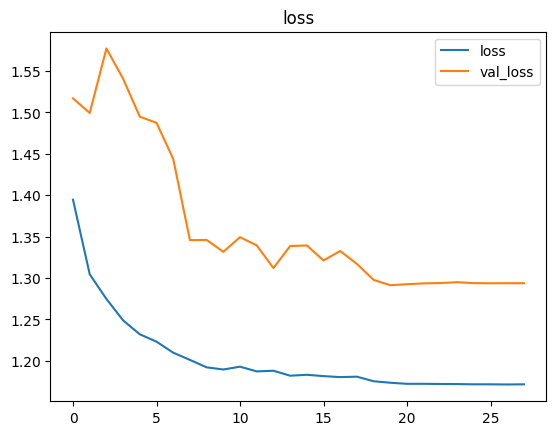

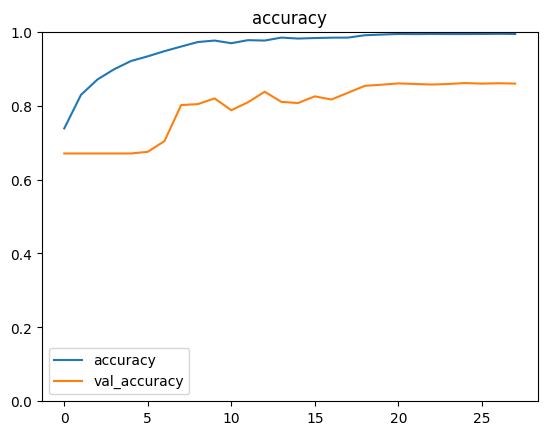

In [3]:
df = pd.read_csv(configs.CLASSIFIER_CHECKPOINT + 
                 '/history_classifier224_20240705112200.csv')

plt.plot(df['loss'], label='loss')
plt.plot(df['val_loss'], label='val_loss')
plt.legend()
plt.title('loss')
# plt.ylim(0, 3)
plt.show()

plt.plot(df['accuracy'], label='accuracy')
plt.plot(df['val_accuracy'], label='val_accuracy')
plt.legend()
plt.title('accuracy')
plt.ylim(0, 1)
plt.show()

# Evaluation

In [ ]:
model = tf.keras.models.load_model(configs.CLASSIFIER_CHECKPOINT)
train_loss, train_acc = model.evaluate_generator(train_datagen, verbose=1)
val_loss, val_acc = model.evaluate_generator(val_datagen, verbose=1)
test_loss, test_acc = model.evaluate_generator(test_datagen, verbose=1)
print(train_loss, val_loss, test_loss)
print(train_acc, val_acc, test_acc)

<ipython-input-10-b7666df18ef5>:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  train_loss, train_acc = model.evaluate_generator(train_datagen, verbose=1)


157/157 [==============================] - 2057s 13s/step - loss: 1.1717 - accuracy: 0.9938


<ipython-input-10-b7666df18ef5>:3: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  val_loss, val_acc = model.evaluate_generator(val_datagen, verbose=1)


63/63 [==============================] - 838s 14s/step - loss: 1.2914 - accuracy: 0.8565


<ipython-input-10-b7666df18ef5>:4: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  test_loss, test_acc = model.evaluate_generator(test_datagen, verbose=1)


95/95 [==============================] - 1301s 14s/step - loss: 1.3033 - accuracy: 0.8465
1.1717393398284912 1.2914464473724365 1.3033417463302612
0.9938061833381653 0.8565000295639038 0.8465116024017334


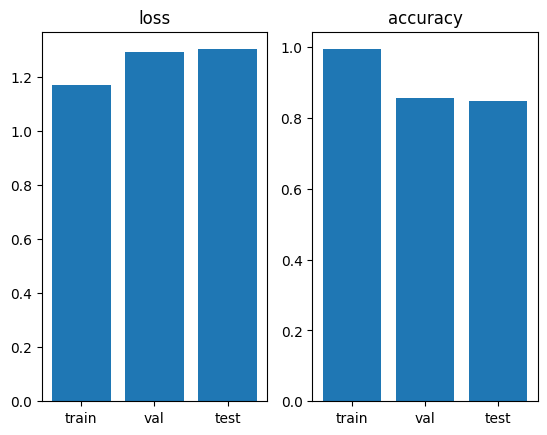

In [ ]:
plt.subplot(1, 2, 1)
plt.bar(['train', 'val', 'test'], [1.1717, 1.2914, 1.3033])
plt.title('loss')
plt.subplot(1, 2, 2)
plt.bar(['train', 'val', 'test'], [0.9938, 0.8565, 0.8465])
plt.title('accuracy')
plt.show()